In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import classification_report, confusion_matrix


In [2]:
# Load the data
data = pd.read_csv("Epileptic Seizure Recognition.csv")
data = data.drop(columns=['Unnamed'])

# Separate features (X) and labels (y)
X = data.iloc[:, :-1].values  # Features are all columns except the last one
y = data.iloc[:, -1].values   # The last column is the target

# Convert seizure labels to binary (0: No seizure, 1: Seizure)
y[y > 1] = 0


In [3]:
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, shuffle=True)
# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
# Reshape data for RNN
X_train_scaled = X_train_scaled.reshape((X_train_scaled.shape[0], X_train_scaled.shape[1], 1))
X_test_scaled = X_test_scaled.reshape((X_test_scaled.shape[0], X_test_scaled.shape[1], 1))


In [4]:
# Create the RNN model
model = Sequential()
model.add(LSTM(64, return_sequences=True))
model.add(Dropout(0.2))  # Add dropout for regularization
model.add(LSTM(64, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [5]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ModelCheckpoint('best_rnn_model.keras', save_best_only=True, monitor='val_loss')
]
# Train the model
model.fit(X_train_scaled, y_train, epochs=150, batch_size=128, validation_split=0.2, callbacks=callbacks)

Epoch 1/150
58/58 ━━━━━━━━━━━━━━━━━━━━ 29s 350ms/step - accuracy: 0.8357 - loss: 0.4744 - val_accuracy: 0.9576 - val_loss: 0.1183
Epoch 2/150
58/58 ━━━━━━━━━━━━━━━━━━━━ 19s 326ms/step - accuracy: 0.9628 - loss: 0.1155 - val_accuracy: 0.9701 - val_loss: 0.0796
Epoch 3/150
58/58 ━━━━━━━━━━━━━━━━━━━━ 19s 324ms/step - accuracy: 0.9708 - loss: 0.0866 - val_accuracy: 0.9739 - val_loss: 0.0642
Epoch 4/150
58/58 ━━━━━━━━━━━━━━━━━━━━ 19s 328ms/step - accuracy: 0.9661 - loss: 0.0900 - val_accuracy: 0.9755 - val_loss: 0.0620
Epoch 5/150
58/58 ━━━━━━━━━━━━━━━━━━━━ 21s 331ms/step - accuracy: 0.9672 - loss: 0.0953 - val_accuracy: 0.9707 - val_loss: 0.0698
Epoch 6/150
58/58 ━━━━━━━━━━━━━━━━━━━━ 19s 330ms/step - accuracy: 0.9731 - loss: 0.0778 - val_accuracy: 0.9788 - val_loss: 0.0537
Epoch 7/150
58/58 ━━━━━━━━━━━━━━━━━━━━ 19s 323ms/step - accuracy: 0.9737 - loss: 0.0725 - val_accuracy: 0.9810 - val_loss: 0.0631
Epoch 8/150
58/58 ━━━━━━━━━━━━━━━━━━━━ 19s 322ms/step - accuracy: 0.9776 - loss: 0.0764 - 

In [6]:
# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test_scaled, y_test)
print("Loss:", loss)
print("Accuracy:", accuracy * 100, "%")
print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}")

predictions = model.predict(X_test_scaled)
predictions = (predictions > 0.5).astype(int)
print(classification_report(y_test, predictions))
print(confusion_matrix(y_test, predictions))

72/72 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.9757 - loss: 0.0662
Loss: 0.05785604566335678
Accuracy: 97.78260588645935 %
Test Loss: 0.0579, Test Accuracy: 0.9778
72/72 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      1857
           1       0.92      0.96      0.94       443

    accuracy                           0.98      2300
   macro avg       0.96      0.97      0.96      2300
weighted avg       0.98      0.98      0.98      2300

[[1822   35]
 [  16  427]]


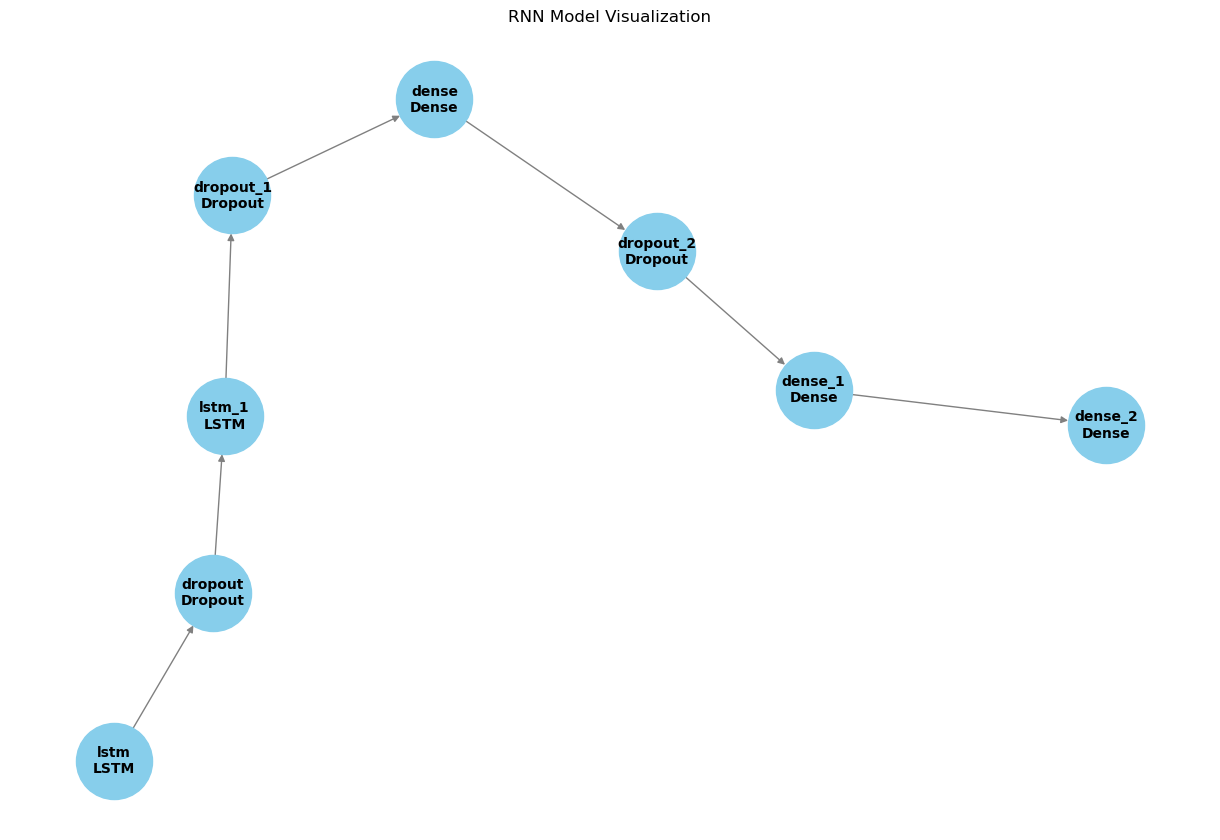

In [7]:
#Visualize the model

import networkx as nx
import matplotlib.pyplot as plt

def visualize_model_rnn(model, file_name="rnn_model.png"):
    G = nx.DiGraph()

    for i, layer in enumerate(model.layers):
        # Add layer name and type to the node
        G.add_node(i, label=f"{layer.name}\n{layer.__class__.__name__}")
        
    for i in range(len(model.layers) - 1):
        G.add_edge(i, i + 1)

    pos = nx.spring_layout(G)
    labels = nx.get_node_attributes(G, 'label')

    plt.figure(figsize=(12, 8))
    nx.draw(G, pos, labels=labels, with_labels=True, node_size=3000, node_color='skyblue', font_size=10, font_weight='bold', font_color='black', edge_color='gray')

    plt.title("RNN Model Visualization")
    plt.savefig(file_name, format="png")
    plt.show()

# Call the function to visualize and save the RNN model
visualize_model_rnn(model, file_name="rnn_model.png")